<h1>Importações</h1>

In [79]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
mt5.initialize()
ativo ='WDO$N'
graf_diario = pd.DataFrame(mt5.copy_rates_from_pos(ativo, mt5.TIMEFRAME_D1, 0, 135))
graf_diario['time'] = pd.to_datetime(graf_diario['time'],unit='s')
ptax = pd.read_excel('historico_ptax.xlsx')
ptax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6580 entries, 0 to 6579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    6580 non-null   datetime64[ns]
 1   Ptax    6580 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 102.9 KB


<h1>Estimar onde vai vir as próximas prévias</h1>

In [80]:
previas = {'Data':[],'Prev_1':[],'Prev_2':[],'Prev_3':[],'Prev_4':[]}
for data,ptax in list(ptax.values):
    ptax = ptax * 1000
    if len(previas['Data']) == 0:
        previas['Data'].append(data.date())
        
    if data.date() != previas['Data'][-1] and (data.time() == datetime.time(10) or data.time() == datetime.time(11) or data.time() == datetime.time(12) or data.time() == datetime.time(13)) :
        previas['Data'].append(data.date())
        
    if data.date() == previas['Data'][-1] and data.time() == datetime.time(10):
        previas['Prev_1'].append(ptax)
        if len(previas['Data']) != len(previas['Prev_1']):
            previas['Prev_1'].append(None)
            
    elif data.date() == previas['Data'][-1]  and data.time() == datetime.time(11):
        previas['Prev_2'].append(ptax)
        if len(previas['Data'])  != len(previas['Prev_2']):
            previas['Prev_2'].append(None)
            
    elif data.date() == previas['Data'][-1] and data.time() == datetime.time(12):
        previas['Prev_3'].append(ptax)
        if len(previas['Data'])  != len(previas['Prev_3']):
            previas['Prev_3'].append(None)
            
    elif data.date() == previas['Data'][-1] and data.time() == datetime.time(13):
        previas['Prev_4'].append(ptax)     
        if len(previas['Data'])  != len(previas['Prev_4']):
            previas['Prev_4'].append(None)
            
print(len(previas['Data']),len(previas['Prev_1']),len(previas['Prev_2']),len(previas['Prev_3']),len(previas['Prev_4']))

1656 1656 1656 1656 1656


In [81]:
previas = pd.DataFrame(previas)
previas['Dif_prev1'] = abs(previas['Prev_1'] - previas['Prev_1'].shift(-1))
previas['Dif_prev2'] = abs(previas['Prev_2'] - previas['Prev_2'].shift(-1))
previas['Dif_prev3'] = abs(previas['Prev_3'] - previas['Prev_3'].shift(-1))
previas['Dif_prev4'] = abs(previas['Prev_4'] - previas['Prev_4'].shift(-1))
previas['Prev2-Prev1'] = abs(previas['Prev_2'] - previas['Prev_1'])
previas['Prev3-Prev2'] = abs(previas['Prev_3'] - previas['Prev_2'])
previas['Prev4-Prev3'] = abs(previas['Prev_4'] - previas['Prev_3'])
previas[0:63].describe()

,Prev_1,Prev_2,Prev_3,Prev_4,Dif_prev1,Dif_prev2,Dif_prev3,Dif_prev4,Prev2-Prev1,Prev3-Prev2,Prev4-Prev3
count,63.000000,63.0000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,4878.036508,4878.4000,4878.966667,4877.649206,25.428571,27.757143,28.279365,28.644444,10.674603,9.544444,7.082540
std,80.228018,79.9511,78.297757,78.923809,19.309060,23.315547,20.755552,21.049947,9.296548,6.890732,5.732182
min,4714.500000,4723.0000,4722.400000,4716.300000,0.700000,0.100000,0.000000,0.400000,0.500000,0.300000,0.500000
25%,4807.600000,4806.9500,4817.000000,4816.400000,10.350000,8.900000,9.950000,11.750000,3.000000,3.450000,2.800000
50%,4882.400000,4882.9000,4880.900000,4877.600000,22.000000,20.000000,23.500000,20.300000,8.500000,8.700000,5.500000
75%,4933.800000,4931.3000,4937.300000,4934.800000,35.500000,38.500000,40.050000,44.650000,16.450000,13.050000,10.850000
max,5052.500000,5055.2000,5045.700000,5057.000000,89.800000,117.200000,81.200000,76.900000,45.100000,27.400000,30.300000


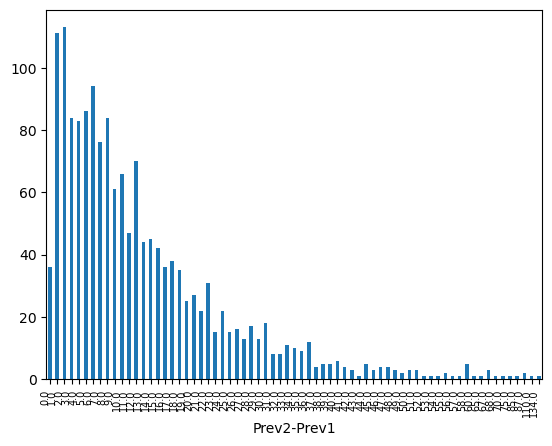

In [82]:
#Gráfico distribuição da diferença entre a prévia 1 e 2
x = previas['Prev2-Prev1'].groupby(round(previas['Prev2-Prev1'])).count()
frequencia = x.sort_index()
frequencia.plot(kind='bar')
plt.xticks(rotation=90,ha="right",fontsize=7)
plt.show()

<h1>Probabilidade de vir buscar a ptax_oficial do dia anterior</h1>

In [83]:
#Probabilidade de vir buscar a ptax_oficial do dia anterior
ptax_oficial = pd.read_csv('CotacoesMoedasPeriodo.csv',sep=';')
frp0 = pd.read_excel('frp0.xlsx')
ptax_oficial['venda'] = ptax_oficial['venda'].str.replace(',','.')
ptax_oficial['venda']= ptax_oficial['venda'].astype(float)
ptax_oficial ['venda']= (ptax_oficial ['venda']*1000)
ptax_oficial = pd.concat([ptax_oficial,frp0],axis=1)
ptax_oficial['ptax_futura'] = ptax_oficial['venda'] + ptax_oficial['FRP0']
ptax_oficial[['Data','venda']]
contador_dias_ptax = 0
contador_diario = 4
ficou_acima_ficou_Abaixo = 0
for data_ptax in ptax_oficial['Data']:
    for data_diario in graf_diario['time'][3:130]:
        if data_ptax.date() == data_diario.date():
            # ficou_acima_ficou_Abaixo+=1
            # print(data_ptax,data_diario,graf_diario['high'].iloc[contador_diario],ptax_oficial['ptax_futura'][contador_dias_ptax],graf_diario['low'].iloc[contador_diario])
            if graf_diario['high'].iloc[contador_diario] > ptax_oficial['ptax_futura'][contador_dias_ptax] and graf_diario['low'].iloc[contador_diario] < ptax_oficial['ptax_futura'][contador_dias_ptax]:
                ficou_acima_ficou_Abaixo+=1
        contador_diario+=1
    contador_diario = 4
    contador_dias_ptax+=1
print(ficou_acima_ficou_Abaixo,ficou_acima_ficou_Abaixo/127)
ptax_oficial[['Data','ptax_futura']]

87 0.6850393700787402


,Data,ptax_futura
0,2023-03-23,5272.2
1,2023-03-24,5298.9
2,2023-03-27,5235.9
3,2023-03-28,5176.7
4,2023-03-29,5150.7
...,...,...
122,2023-09-18,4862.3
123,2023-09-19,4864.9
124,2023-09-20,4854.7
125,2023-09-21,4929.6
